# 0. Install and Import Dependencies

In [1]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.9.0
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
altair                        5.2.0
anaconda-anon-usage           0.4.3
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy    

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

You should consider upgrading via the '/Users/visheshyadav/anaconda3/bin/python3.11 -m pip install --upgrade pip' command.


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    #           path.split('/')[-1].split('.')[0]    
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = './data/s1/bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

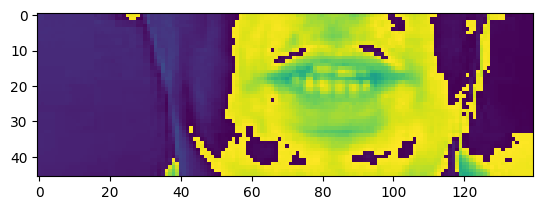

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[1.3085452 ],
          [1.3085452 ],
          [1.3085452 ],
          ...,
          [9.384139  ],
          [0.07477402],
          [9.4963    ]],

         [[1.3085452 ],
          [1.3085452 ],
          [1.3085452 ],
          ...,
          [9.4963    ],
          [9.4963    ],
          [9.384139  ]],

         [[1.2711583 ],
          [1.2711583 ],
          [1.2711583 ],
          ...,
          [0.11216103],
          [0.        ],
          [0.        ]],

         ...,

         [[0.8972882 ],
          [0.8972882 ],
          [0.8972882 ],
          ...,
          [9.458913  ],
          [9.421526  ],
          [9.421526  ]],

         [[0.8599012 ],
          [0.8599012 ],
          [0.8599012 ],
          ...,
          [9.421526  ],
          [9.384139  ],
          [9.384139  ]],

         [[0.8599012 ],
          [0.8599012 ],
          [0.8599012 ],
          ...,
          [9.421526  ],
          [9.384139  ],
          [9.384139  ]]],


        [[[1.3085

In [31]:
from PIL import Image
import numpy as np

# Assuming `val` is a tuple containing the numpy array
# Access the numpy array from the tuple
image_array = val[0][0]

# Select the first image from the sequence
first_image = image_array[0]

# # Convert the array to a 2-dimensional grayscale image (assuming the array represents a grayscale image)
img = Image.fromarray(first_image.squeeze(), mode='L')

# # Resize the image if needed
# input_size = (255, 255)  # Set desired width and height
# resized_img = img.resize(input_size)

# # Convert the image to RGB if needed
# rgb_img = resized_img.convert('RGB')

# Now you can use `rgb_img` as needed in your code




In [32]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)
# imageio.mimsave('./animation.gif', rgb_img, duration=100)  # Set duration to 1000 ms / 10 fps




rgb_img_sequence = [img]  # Convert the image object into a sequence

# Save the sequence of images to a file
imageio.mimwrite('./animation.gif', rgb_img_sequence, duration=100)



In [33]:
test=data.as_numpy_iterator()

In [34]:
val=test.next();val[0]

array([[[[[ 1.442388  ],
          [ 1.442388  ],
          [ 1.3644211 ],
          ...,
          [ 9.161113  ],
          [ 9.667898  ],
          [ 9.784848  ]],

         [[ 1.442388  ],
          [ 1.442388  ],
          [ 1.3644211 ],
          ...,
          [ 9.005179  ],
          [ 9.745865  ],
          [ 9.784848  ]],

         [[ 1.3644211 ],
          [ 1.3644211 ],
          [ 1.3644211 ],
          ...,
          [ 9.901798  ],
          [ 0.03898346],
          [ 0.03898346]],

         ...,

         [[ 0.935603  ],
          [ 0.935603  ],
          [ 0.935603  ],
          ...,
          [ 9.823832  ],
          [ 9.784848  ],
          [ 9.823832  ]],

         [[ 0.935603  ],
          [ 0.935603  ],
          [ 0.935603  ],
          ...,
          [ 9.745865  ],
          [ 9.784848  ],
          [ 9.784848  ]],

         [[ 0.935603  ],
          [ 0.935603  ],
          [ 0.935603  ],
          ...,
          [ 9.745865  ],
          [ 9.784848  ],
          

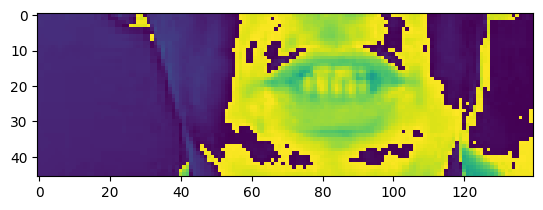

In [35]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by g one again'>

# 3. Design the Deep Neural Network

In [37]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [38]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [41]:
5*17*75

6375

In [42]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [43]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa '>

In [44]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa '>

In [45]:
model.input_shape

(None, 75, 46, 140, 1)

In [46]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [47]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [48]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [56]:
# class ProduceExample(tf.keras.callbacks.Callback): 
#     def __init__(self, dataset) -> None: 
#         self.dataset = dataset.as_numpy_iterator()
    
#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):           
#             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('~'*100)

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = iter(dataset)
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = next(self.dataset)
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [57]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [58]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [59]:
schedule_callback = LearningRateScheduler(scheduler)

In [66]:
example_callback = ProduceExample(test)

In [69]:
# model.load_weights('model/models-checkpoint50.zip')
# model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

2024-06-06 05:49:38.942511: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open model/models-checkpoint50.zip: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


OSError: Unable to open file (file signature not found)

# 5. Make a Prediction 

In [71]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=22d2840e-138a-4e3c-bb7d-b6ec900263ab
To: /Users/visheshyadav/Documents/GitHub/Lip-Sync-Reader/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:25<00:00, 3.73MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [74]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
model.compile(optimizer=legacy_optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)

In [75]:

model.load_weights('models/checkpoint')

In [77]:
# test_data = test.as_numpy_iterator()
test_data = iter(test)


In [79]:
sample = next(test_data)

In [80]:
sample = test_data.next()

In [81]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [82]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green in o nine again'>]

In [83]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [84]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green in o nine again'>]

# Test on a Video

In [87]:
# sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

import os
import tensorflow as tf
from typing import List

def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame from {path}")
            break
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path: str) -> List[str]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Alignment file not found: {path}")
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    
    # Debugging statements
    print(f"Decoded path: {path}")
    print(f"Extracted file name: {file_name}")
    
    if not file_name:
        raise ValueError("File name could not be extracted from the path.")
    
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    # Debugging statements
    print(f"Video path: {video_path}")
    print(f"Alignment path: {alignment_path}")
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

# Example usage
try:
    sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))
except FileNotFoundError as e:
    print(e)
except ValueError as e:
    print(e)

Decoded path: .\data\s1\bras9a.mpg
Extracted file name: 
File name could not be extracted from the path.


In [88]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u six pleaseset green in o nine again'>]

In [97]:
# yhat = model.predict(tf.expand_dims(sample[0], axis=0))

import zipfile
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Extract the zip file
zip_path = 'models - checkpoint 50.zip'
extract_to = 'models/checkpoint50'

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Define your model architecture
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

# Compile the model with the legacy optimizer
model.compile(optimizer=legacy_optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)

# Load the weights from the extracted directory
status = model.load_weights('models/checkpoint')
status.expect_partial()
# Create an iterator for the test dataset
test_data = iter(test)

# Get the next batch from the test dataset
sample = next(test_data)

# Check the shape of sample[0]
print(f"Shape of sample[0]: {sample[0].shape}")

# Use sample[0] directly without expanding dimensions
input_data = sample[0]
print(f"Shape of input_data: {input_data.shape}")

# Make predictions
yhat = model.predict(input_data)

# Decode predictions
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()
# Print predictions
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

Shape of sample[0]: (2, 75, 46, 140, 1)
Shape of input_data: (2, 75, 46, 140, 1)


1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in n one soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u one again'>]

In [100]:
# Decode predictions
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [101]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in n one soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u one again'>]

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


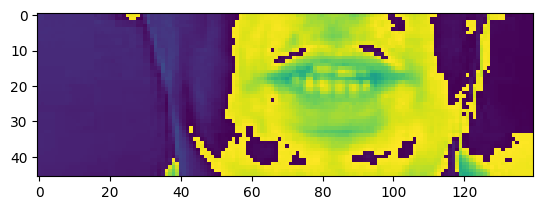

In [102]:
# import os
# import cv2
# import tensorflow as tf
# import numpy as np
# from typing import List
# from matplotlib import pyplot as plt
# import imageio
# tf.config.list_physical_devices('GPU')
# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#     pass

# import gdown
# def load_video(path:str) -> List[float]: 

#     cap = cv2.VideoCapture(path)
#     frames = []
#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
#         ret, frame = cap.read()
#         frame = tf.image.rgb_to_grayscale(frame)
#         frames.append(frame[190:236,80:220,:])
#     cap.release()
    
#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std

# vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# num_to_char = tf.keras.layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
# )

# print(
#     f"The vocabulary is: {char_to_num.get_vocabulary()} "
#     f"(size ={char_to_num.vocabulary_size()})"
# )


# char_to_num.get_vocabulary()

# char_to_num(['n','i','c','k'])

# num_to_char([14,  9,  3, 11])

# def load_alignments(path:str) -> List[str]: 
#     with open(path, 'r') as f: 
#         lines = f.readlines() 
#     tokens = []
#     for line in lines:
#         line = line.split()
#         if line[2] != 'sil': 
#             tokens = [*tokens,' ',line[2]]
#     return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

# def load_data(path: str): 
#     path = bytes.decode(path.numpy())
#     #file_name = path.split('/')[-1].split('.')[0]
#     # File name splitting for windows
#     file_name = path.split('/')[-1].split('.')[0]
#     #           path.split('/')[-1].split('.')[0]    
#     video_path = os.path.join('data','s1',f'{file_name}.mpg')
#     alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
#     frames = load_video(video_path) 
#     alignments = load_alignments(alignment_path)
    
#     return frames, alignments

# test_path = './data/s1/bbal6n.mpg'

# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

# frames, alignments = load_data(tf.convert_to_tensor(test_path))

# plt.imshow(frames[40])

# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

# def mappable_function(path:str) ->List[str]:
#     result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
#     return result

# data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)
# data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# data = data.prefetch(tf.data.AUTOTUNE)
# # Added for split 
# train = data.take(450)
# test = data.skip(450)

# frames, alignments = data.as_numpy_iterator().next()

# len(frames)

# sample = data.as_numpy_iterator()

# val = sample.next(); val[0]

# from PIL import Image
# import numpy as np

# # Assuming `val` is a tuple containing the numpy array
# # Access the numpy array from the tuple
# image_array = val[0][0]

# # Select the first image from the sequence
# first_image = image_array[0]

# # # Convert the array to a 2-dimensional grayscale image (assuming the array represents a grayscale image)
# img = Image.fromarray(first_image.squeeze(), mode='L')

# # # Resize the image if needed
# # input_size = (255, 255)  # Set desired width and height
# # resized_img = img.resize(input_size)

# # # Convert the image to RGB if needed
# # rgb_img = resized_img.convert('RGB')

# # Now you can use `rgb_img` as needed in your code



# rgb_img_sequence = [img]  # Convert the image object into a sequence

# # Save the sequence of images to a file
# imageio.mimwrite('./animation.gif', rgb_img_sequence, duration=100)

# test=data.as_numpy_iterator()

# val=test.next();val[0]

# # 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
# plt.imshow(val[0][0][35])

# tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])



# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# data.as_numpy_iterator().next()[0][0].shape


# model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(256, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(75, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

# yhat = model.predict(val[0])
# tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

# tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

# def scheduler(epoch, lr):
#     if epoch < 30:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
    

# def CTCLoss(y_true, y_pred):
#     batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#     input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#     label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#     input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#     label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

#     loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
#     return loss


# class ProduceExample(tf.keras.callbacks.Callback): 
#     def __init__(self, dataset) -> None: 
#         self.dataset = iter(dataset)
    
#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = next(self.dataset)
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):           
#             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('~'*100)

# model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
# schedule_callback = LearningRateScheduler(scheduler)
# example_callback = ProduceExample(test)



# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

# from tensorflow.keras.optimizers import legacy as legacy_optimizers
# model.compile(optimizer=legacy_optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)


# model.load_weights('models/checkpoint')

# # test_data = test.as_numpy_iterator()
# test_data = iter(test)
# sample = next(test_data)

# yhat = model.predict(sample[0])

# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]




# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

# print('~'*100, 'PREDICTIONS')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# # sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

# import os
# import tensorflow as tf
# from typing import List

# def load_video(path: str) -> List[float]:
#     cap = cv2.VideoCapture(path)
#     frames = []
#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         if not ret:
#             print(f"Failed to read frame from {path}")
#             break
#         frame = tf.image.rgb_to_grayscale(frame)
#         frames.append(frame[190:236, 80:220, :])
#     cap.release()

#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std

# def load_alignments(path: str) -> List[str]:
#     if not os.path.exists(path):
#         raise FileNotFoundError(f"Alignment file not found: {path}")
#     with open(path, 'r') as f:
#         lines = f.readlines()
#     tokens = []
#     for line in lines:
#         line = line.split()
#         if line[2] != 'sil':
#             tokens = [*tokens, ' ', line[2]]
#     return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

# def load_data(path: str):
#     path = bytes.decode(path.numpy())
#     file_name = path.split('/')[-1].split('.')[0]
    
#     # Debugging statements
#     print(f"Decoded path: {path}")
#     print(f"Extracted file name: {file_name}")
    
#     if not file_name:
#         raise ValueError("File name could not be extracted from the path.")
    
#     video_path = os.path.join('data', 's1', f'{file_name}.mpg')
#     alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
#     # Debugging statements
#     print(f"Video path: {video_path}")
#     print(f"Alignment path: {alignment_path}")
    
#     frames = load_video(video_path)
#     alignments = load_alignments(alignment_path)
#     return frames, alignments

# # Example usage
# try:
#     sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))
# except FileNotFoundError as e:
#     print(e)
# except ValueError as e:
#     print(e)



# print('~'*100, 'REAL TEXT')
# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

# [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

